In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['NUMEXPR_NUM_THREADS'] = '12'
import numexpr as ne

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE

import spacy
import re  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
df = pd.read_csv('datasets/simpsons_dataset.csv')
print(df.shape)
df.head()

(158314, 2)


,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [3]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [4]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling named Enity recognition for speed

def cleaning(doc):
    # lemmatizes and remove stop words
    # doc need to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence if only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

print(f'Time to clean up everything: {round(time() - t )/60, 2} mins')

Time to clean up everything: (2.05, 2) mins


In [5]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85956, 1)

In [6]:
df_clean.head()

,clean
0,actually little disease magazine news show nat...
2,know sure like talk touch lesson plan teach
3,life worth live
4,poll open end recess case decide thought final...
7,victory party slide


In [7]:
df_clean.to_csv('clean_simpsons.csv')

In [8]:
from gensim.models.phrases import Phrases, Phraser

sent = [row.split() for row in df_clean['clean']]

phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)

sentences = bigram[sent]

INFO - 15:32:50: collecting all words and their counts
INFO - 15:32:50: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:32:50: PROGRESS: at sentence #10000, processed 63557 words and 52733 word types
INFO - 15:32:50: PROGRESS: at sentence #20000, processed 130938 words and 99702 word types
INFO - 15:32:50: PROGRESS: at sentence #30000, processed 192959 words and 138314 word types
INFO - 15:32:50: PROGRESS: at sentence #40000, processed 249828 words and 172378 word types
INFO - 15:32:50: PROGRESS: at sentence #50000, processed 311267 words and 208202 word types
INFO - 15:32:51: PROGRESS: at sentence #60000, processed 373573 words and 243255 word types
INFO - 15:32:51: PROGRESS: at sentence #70000, processed 436422 words and 278194 word types
INFO - 15:32:51: PROGRESS: at sentence #80000, processed 497885 words and 311308 word types
INFO - 15:32:51: collected 330094 token types (unigram + bigrams) from a corpus of 537096 words and 85956 sentences
INFO - 15:32:51: m

In [9]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))

sorted(word_freq, key=word_freq.get, reverse=True)[:10]

29493


['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

In [10]:
import multiprocessing
from gensim.models import Word2Vec

cores = multiprocessing.cpu_count()

In [11]:
# from gensim import utils

# class MyCorpus(object):
#     """An iterator that yields sentences (list of str)"""
    
#     def __iter__(self):
#         for line in open('clean_simpsons.csv'):
#             # assume there's one document per line, token separated by whitespace
#             yield utils.simple_preprocess(line)
# sentenses = MyCorpus()

In [12]:
count = 0
for i in sentences:
    print(i)
    if count == 10:
        break
    count += 1

['actually', 'little', 'disease', 'magazine', 'news', 'show', 'natural', 'think']
['know', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach']
['life', 'worth', 'live']
['poll', 'open', 'end', 'recess', 'case', 'decide', 'thought', 'final', 'statement', 'martin']
['victory', 'party', 'slide']
['mr', 'bergstrom', 'mr', 'bergstrom']
['hey', 'hey', 'move', 'morning', 'new', 'job', 'take', 'copernicus', 'costume']
['think', 'take', 'train', 'capital_city']
['train', 'like', 'traditional', 'environmentally', 'sound']
['yes', 'backbone', 'country', 'leland', 'stanford', 'drive', 'golden', 'spike', 'promontory', 'point']
['hey', 'thank', 'vote', 'man']


In [13]:
w2v_model = Word2Vec(min_count=20,
                     window=20,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

INFO - 15:32:53: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.03)', 'datetime': '2021-05-14T15:32:53.898191', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [14]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print(f'Time to build vocabulary: {round((time() - t)/60, 2)}')

INFO - 15:32:53: collecting all words and their counts
INFO - 15:32:53: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:32:54: PROGRESS: at sentence #10000, processed 61705 words, keeping 9474 word types
INFO - 15:32:54: PROGRESS: at sentence #20000, processed 127321 words, keeping 14329 word types
INFO - 15:32:54: PROGRESS: at sentence #30000, processed 187814 words, keeping 17358 word types
INFO - 15:32:54: PROGRESS: at sentence #40000, processed 243317 words, keeping 20021 word types
INFO - 15:32:54: PROGRESS: at sentence #50000, processed 303178 words, keeping 22426 word types
INFO - 15:32:54: PROGRESS: at sentence #60000, processed 363915 words, keeping 24662 word types
INFO - 15:32:54: PROGRESS: at sentence #70000, processed 425375 words, keeping 26806 word types
INFO - 15:32:55: PROGRESS: at sentence #80000, processed 485511 words, keeping 28619 word types
INFO - 15:32:55: collected 29493 word types from a corpus of 523625 raw words and 85956 sentence

Time to build vocabulary: 0.02


In [15]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, )

INFO - 15:32:55: Word2Vec lifecycle event {'msg': 'training model with 11 workers on 3316 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=20', 'datetime': '2021-05-14T15:32:55.287497', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
INFO - 15:32:56: EPOCH 1 - PROGRESS: at 14.84% examples, 28415 words/s, in_qsize 22, out_qsize 0
INFO - 15:32:56: worker thread finished; awaiting finish of 10 more threads
INFO - 15:32:56: worker thread finished; awaiting finish of 9 more threads
INFO - 15:32:56: worker thread finished; awaiting finish of 8 more threads
INFO - 15:32:56: worker thread finished; awaiting finish of 7 more threads
INFO - 15:32:56: worker thread finished; awaiting finish of 6 more threads
INFO - 15:32:56: worker thread finished; awaiting finish of 5 more threads
INFO - 15:32:56: worker thread finished; awaiting finish of 4 more threads
INFO 

INFO - 15:33:08: worker thread finished; awaiting finish of 4 more threads
INFO - 15:33:08: worker thread finished; awaiting finish of 3 more threads
INFO - 15:33:08: worker thread finished; awaiting finish of 2 more threads
INFO - 15:33:08: worker thread finished; awaiting finish of 1 more threads
INFO - 15:33:08: worker thread finished; awaiting finish of 0 more threads
INFO - 15:33:08: EPOCH - 8 : training on 523625 raw words (199827 effective words) took 1.7s, 119943 effective words/s
INFO - 15:33:09: EPOCH 9 - PROGRESS: at 11.23% examples, 22429 words/s, in_qsize 20, out_qsize 1
INFO - 15:33:10: worker thread finished; awaiting finish of 10 more threads
INFO - 15:33:10: worker thread finished; awaiting finish of 9 more threads
INFO - 15:33:10: worker thread finished; awaiting finish of 8 more threads
INFO - 15:33:10: worker thread finished; awaiting finish of 7 more threads
INFO - 15:33:10: worker thread finished; awaiting finish of 6 more threads
INFO - 15:33:10: worker thread fi

INFO - 15:33:21: worker thread finished; awaiting finish of 6 more threads
INFO - 15:33:21: worker thread finished; awaiting finish of 5 more threads
INFO - 15:33:21: worker thread finished; awaiting finish of 4 more threads
INFO - 15:33:21: worker thread finished; awaiting finish of 3 more threads
INFO - 15:33:21: worker thread finished; awaiting finish of 2 more threads
INFO - 15:33:21: worker thread finished; awaiting finish of 1 more threads
INFO - 15:33:21: worker thread finished; awaiting finish of 0 more threads
INFO - 15:33:21: EPOCH - 16 : training on 523625 raw words (199390 effective words) took 1.7s, 120486 effective words/s
INFO - 15:33:22: EPOCH 17 - PROGRESS: at 18.47% examples, 36693 words/s, in_qsize 19, out_qsize 0
INFO - 15:33:23: worker thread finished; awaiting finish of 10 more threads
INFO - 15:33:23: worker thread finished; awaiting finish of 9 more threads
INFO - 15:33:23: worker thread finished; awaiting finish of 8 more threads
INFO - 15:33:23: worker thread 

INFO - 15:33:34: worker thread finished; awaiting finish of 8 more threads
INFO - 15:33:34: worker thread finished; awaiting finish of 7 more threads
INFO - 15:33:34: worker thread finished; awaiting finish of 6 more threads
INFO - 15:33:34: worker thread finished; awaiting finish of 5 more threads
INFO - 15:33:34: worker thread finished; awaiting finish of 4 more threads
INFO - 15:33:34: worker thread finished; awaiting finish of 3 more threads
INFO - 15:33:34: worker thread finished; awaiting finish of 2 more threads
INFO - 15:33:34: worker thread finished; awaiting finish of 1 more threads
INFO - 15:33:34: worker thread finished; awaiting finish of 0 more threads
INFO - 15:33:34: EPOCH - 24 : training on 523625 raw words (199868 effective words) took 1.6s, 124124 effective words/s
INFO - 15:33:35: EPOCH 25 - PROGRESS: at 13.09% examples, 26492 words/s, in_qsize 22, out_qsize 0
INFO - 15:33:36: worker thread finished; awaiting finish of 10 more threads
INFO - 15:33:36: worker thread 

(5987942, 15708750)

In [16]:
w2v_model.init_sims(replace=True)

WARNING - 15:33:44: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


In [17]:
w2v_model.wv.most_similar(positive=['homer'])

[('marge', 0.577139139175415),
 ('gee', 0.5357086658477783),
 ('bartender', 0.5311242341995239),
 ('homie', 0.5267624855041504),
 ('depressed', 0.5258225798606873),
 ('talk', 0.5181354284286499),
 ('moe', 0.5161337852478027),
 ('good_friend', 0.507184624671936),
 ('tab', 0.5047218203544617),
 ('creepy', 0.49487459659576416)]

In [18]:
w2v_model.wv.most_similar(positive=['marge'])

[('homer', 0.577139139175415),
 ('marriage', 0.575697124004364),
 ('homie', 0.5733438730239868),
 ('brunch', 0.5276592373847961),
 ('rapture', 0.5204215049743652),
 ('impress', 0.5198988914489746),
 ('brownie', 0.5120296478271484),
 ('becky', 0.5044057369232178),
 ('attract', 0.5036575198173523),
 ('snuggle', 0.4911535978317261)]

In [19]:
w2v_model.wv.most_similar(positive=['bart'])

[('lisa', 0.6404212117195129),
 ('mom_dad', 0.6175764203071594),
 ('convince', 0.5821935534477234),
 ('mom', 0.5745143890380859),
 ('assignment', 0.5672341585159302),
 ('bedtime', 0.5596488118171692),
 ('punish', 0.5542793869972229),
 ('argue', 0.5540505051612854),
 ('substitute', 0.5499855279922485),
 ('maggie', 0.5454934239387512)]

In [20]:
w2v_model.wv.similarity('moe', 'tavern')

0.70872957

In [21]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=min(50, arrays.shape[0])).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    #plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    #plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

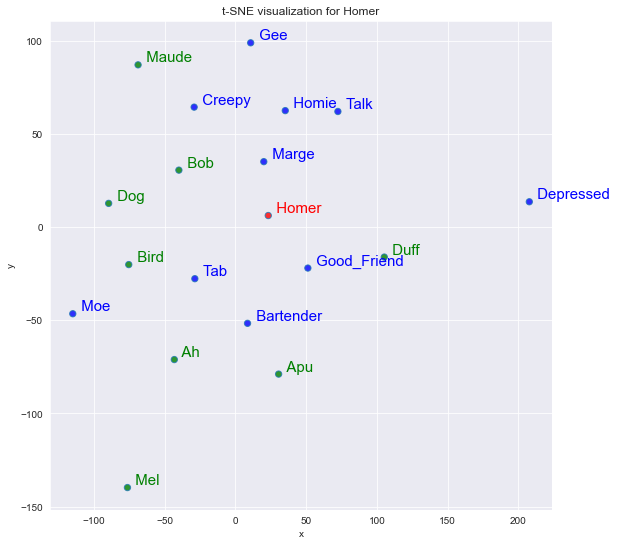

In [22]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

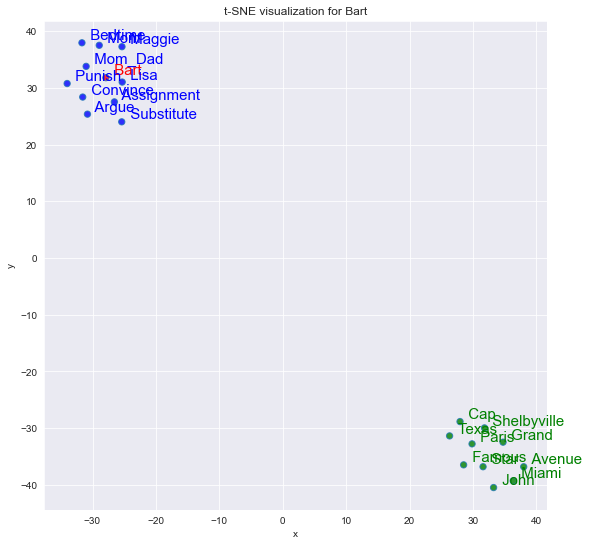

In [23]:
tsnescatterplot(w2v_model, 'bart', [i[0] for i in w2v_model.wv.most_similar(negative=["bart"])])

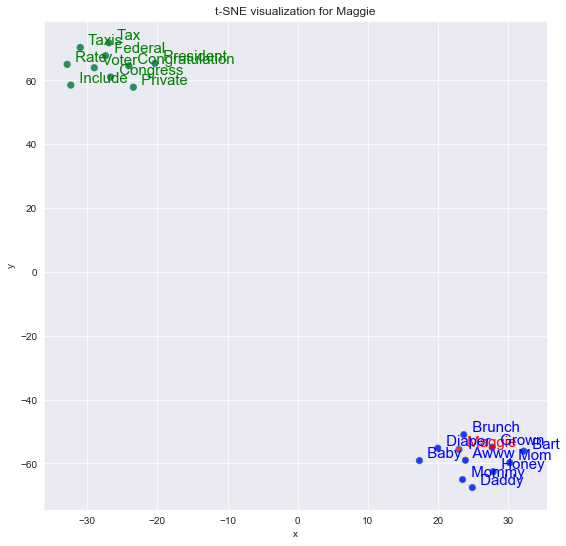

In [24]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

In [25]:
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.key_to_index:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0, n_jobs=-1)
    reduc = PCA(n_components=50).fit_transform(vectors)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')
        
def plot_with_matplotlib(x_vals, y_vals, labels, n_labels=50):
    import random
    random.seed(0)
    plt.figure(figsize=(25, 25))
    plt.scatter(x_vals, y_vals, alpha=0.5)

    #
    # Label randomly subsampled n_labels data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, n_labels)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]), size=14)

In [26]:
x_vals, y_vals, labels = reduce_dimensions(w2v_model)

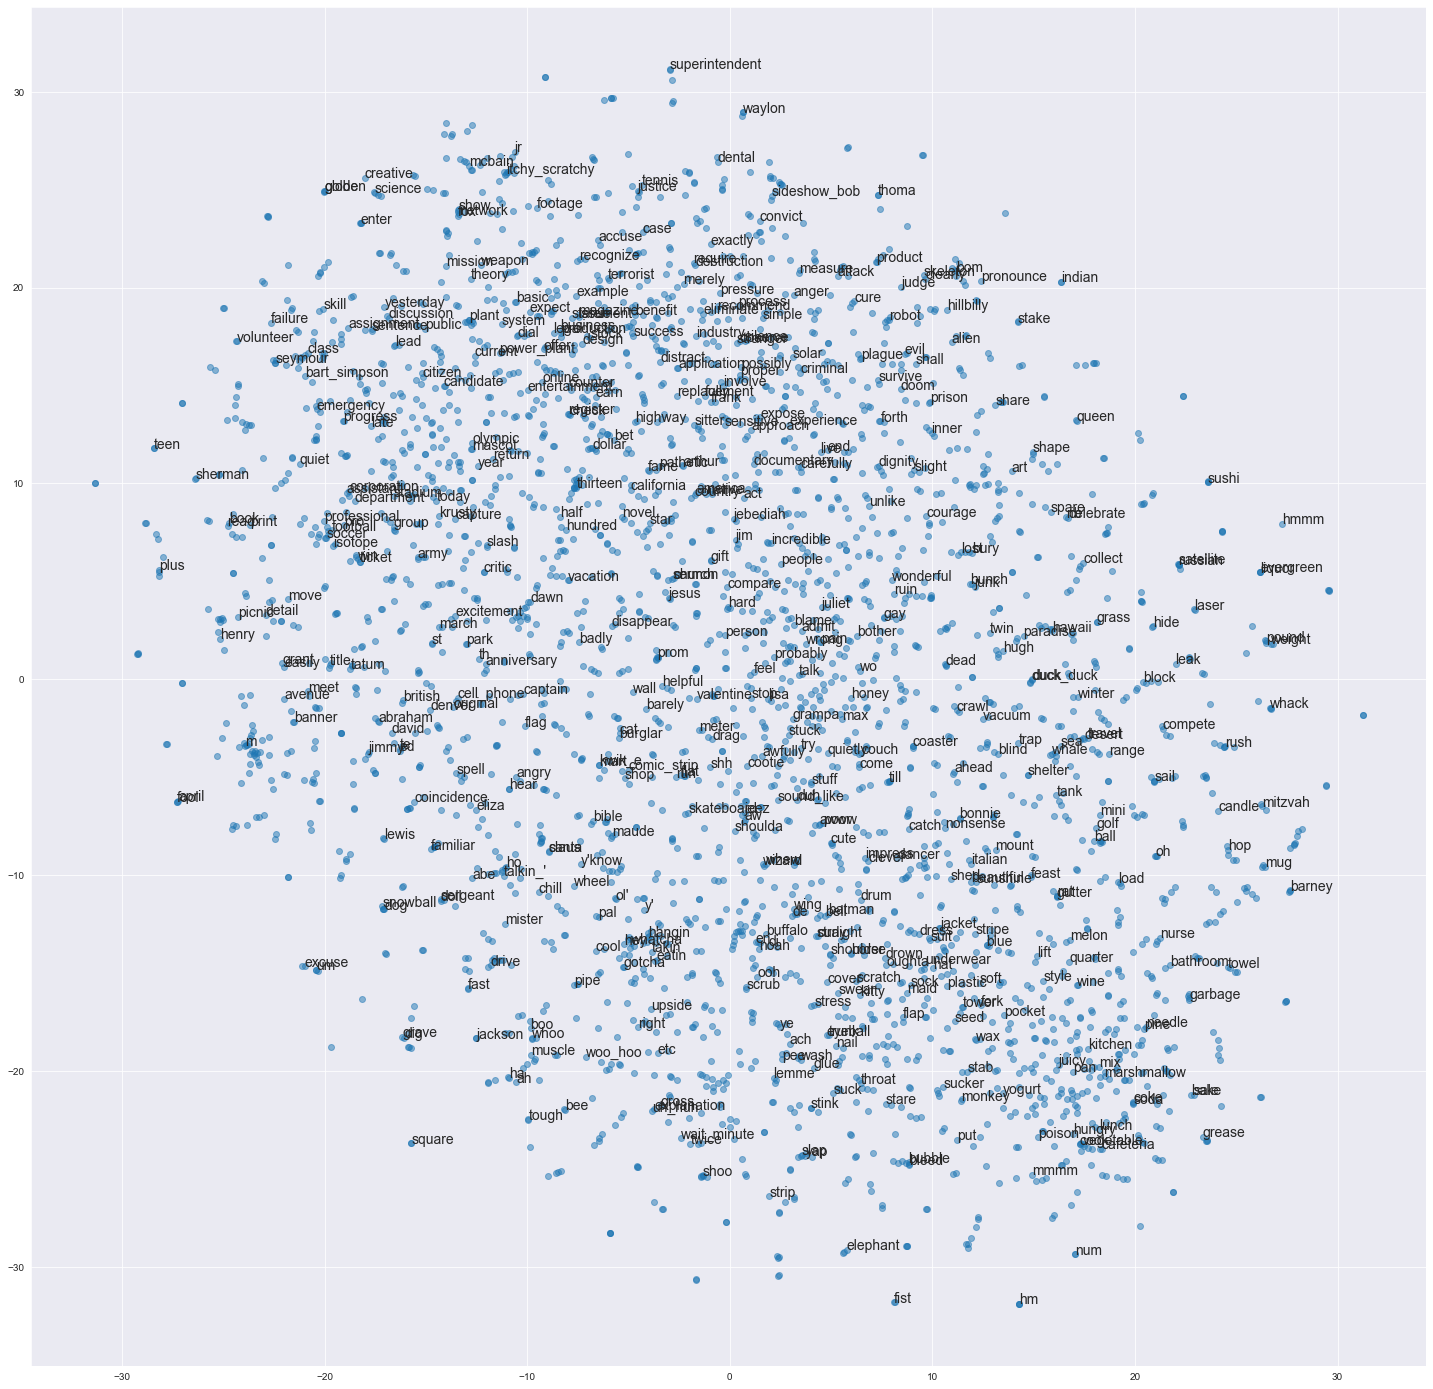

In [27]:
plot_with_matplotlib(x_vals, y_vals, labels, n_labels=500)

In [28]:
plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=False)